In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [81]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [82]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [83]:
# load datasets into a panda's dataframe
real = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
fake = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

In [84]:
fake.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [85]:
#Counting by Subjects 
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

politicsNews:	11272
worldnews:	10145
Total Records:	21417


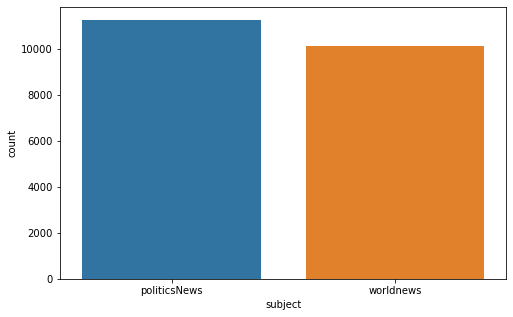

In [86]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake)
plt.show()

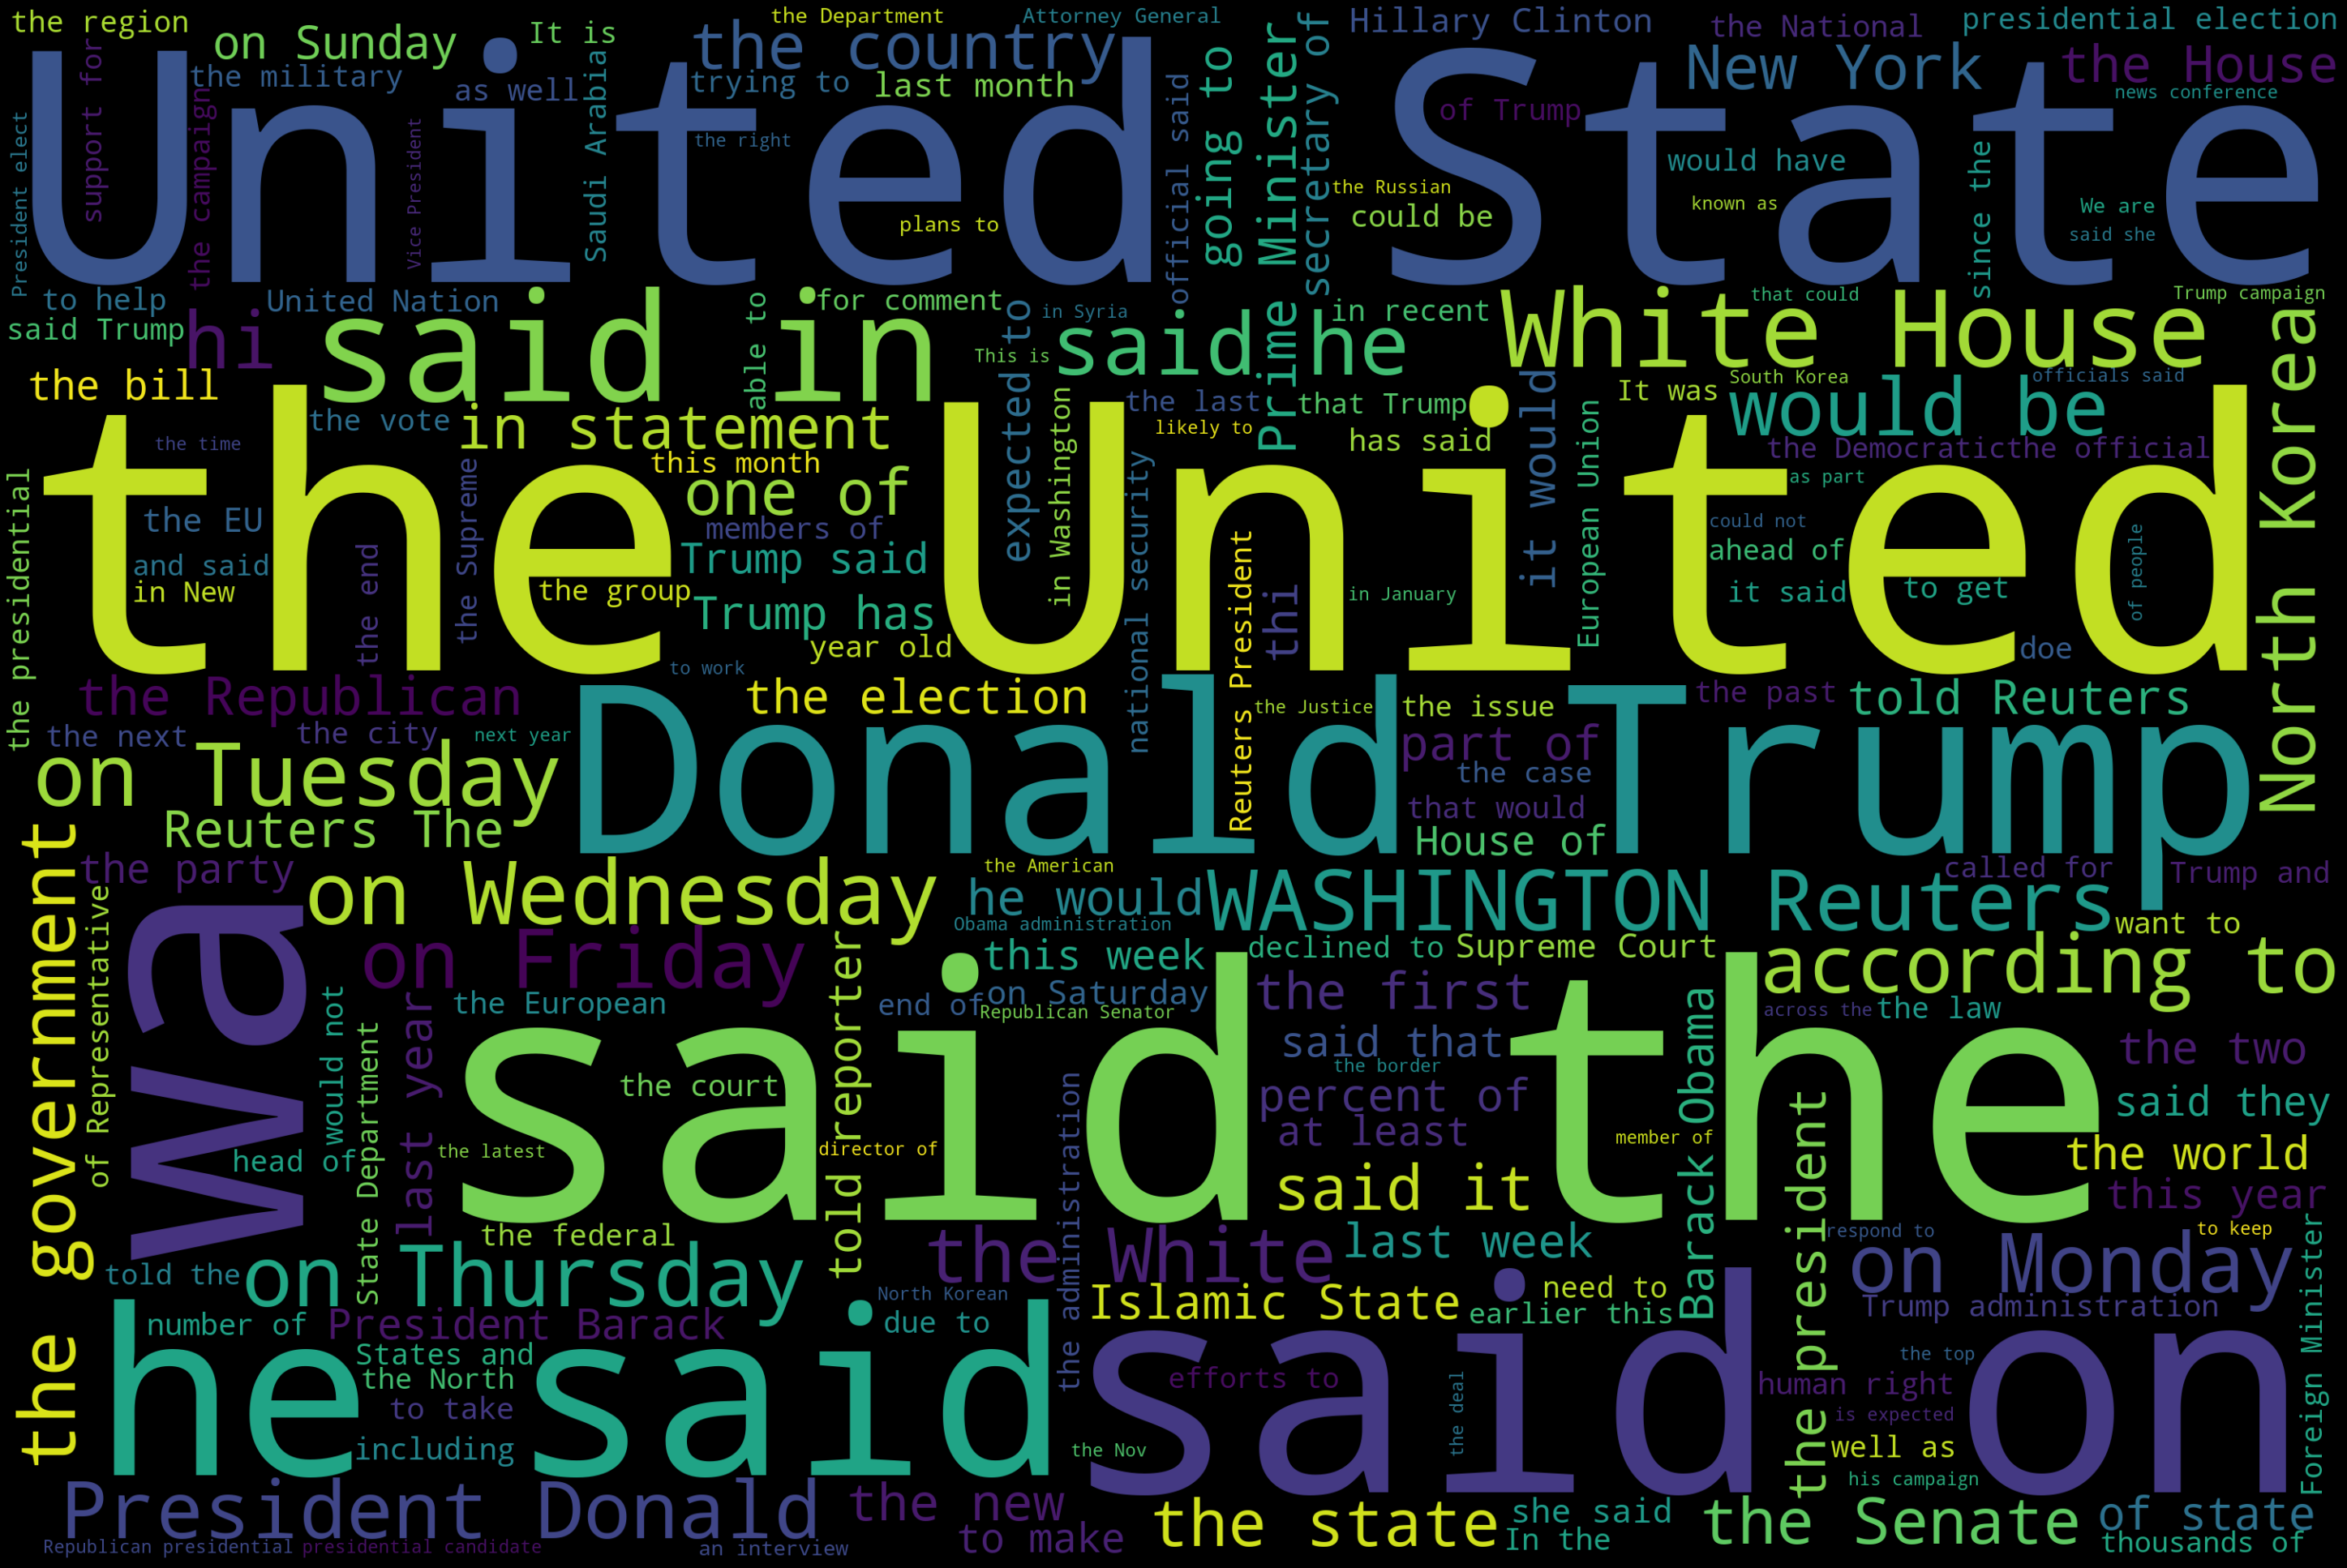

In [87]:
#Word Cloud
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [88]:
real.head()


title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [89]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [90]:
#Thus we have list of indices where publisher is not mentioned
#lets check
real.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

0        Donald Trump just couldn t wish all Americans ...
1        House Intelligence Committee Chairman Devin Nu...
2        On Friday, it was revealed that former Milwauk...
3        On Christmas day, Donald Trump announced that ...
4        Pope Francis used his annual Christmas Day mes...
                               ...                        
23476    21st Century Wire says As 21WIRE reported earl...
23477    21st Century Wire says It s a familiar theme. ...
23478    Patrick Henningsen  21st Century WireRemember ...
23479    21st Century Wire says Al Jazeera America will...
23480    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 23422, dtype: object

In [91]:
real.iloc[8970]
#yep empty
#will remove this soon

title       This Anti-Government Oregon Terrorist Took Th...
text       One of the ringleaders of the terror-minded mi...
subject                                                 News
date                                         January 4, 2016
Name: 8970, dtype: object

In [92]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [93]:
#Replace existing text column with new text
#add seperate column for publication info
real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [94]:
real.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date publisher  
0  December 31, 2017   Unknown  
1  December 31, 2017   Unknown  
2  December 30, 2017   Unknown  
3  December 29, 2017   Unknown  
4  December 25, 2017   Unknown

In [95]:
#checking for rows with empty text like row:8970
[index for index,text in enumerate(real.text.values) if str(text).strip() == '']
#seems only one :)

[10923,
 11041,
 11190,
 11225,
 11236,
 11241,
 11247,
 11249,
 11267,
 11268,
 11283,
 11284,
 11285,
 11289,
 11290,
 11292,
 11295,
 11296,
 11301,
 11303,
 11304,
 11305,
 11309,
 11314,
 11317,
 11319,
 11322,
 11330,
 11334,
 11335,
 11340,
 11343,
 11348,
 11351,
 11352,
 11357,
 11371,
 11373,
 11374,
 11382,
 11397,
 11402,
 11403,
 11409,
 11410,
 11412,
 11415,
 11419,
 11421,
 11427,
 11431,
 11432,
 11440,
 11448,
 11450,
 11453,
 11462,
 11464,
 11465,
 11472,
 11473,
 11475,
 11478,
 11489,
 11491,
 11493,
 11494,
 11501,
 11505,
 11507,
 11520,
 11531,
 11532,
 11533,
 11538,
 11542,
 11547,
 11549,
 11551,
 11559,
 11563,
 11581,
 11585,
 11589,
 11590,
 11614,
 11624,
 11625,
 11627,
 11631,
 11636,
 11637,
 11643,
 11650,
 11658,
 11661,
 11672,
 11679,
 11681,
 11684,
 11686,
 11688,
 11692,
 11708,
 11718,
 11729,
 11739,
 11753,
 11765,
 11768,
 11777,
 11782,
 11786,
 11788,
 11792,
 11793,
 11803,
 11806,
 11813,
 11821,
 11831,
 11832,
 11841,
 11844,
 11848,


In [96]:
#dropping this record
real = real.drop(8970, axis=0)

In [97]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 1


title text       subject            date
8970  Graphic: Supreme Court roundup       politicsNews  June 16, 2016

In [98]:
#Looking at publication Information
# Checking if Some part of text has been included as publisher info... No such cases it seems :)

# for name,count in real.publisher.value_counts().iteritems():
#     print(f"Name: {name}\nCount: {count}\n")

In [99]:
#Getting Total Rows
print(f"Total Records:\t{real.shape[0]}")

#Counting by Subjects 
for key,count in real.subject.value_counts().iteritems():
  print(f"{key}:\t{count}")

Total Records:	23480
News:	9049
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778


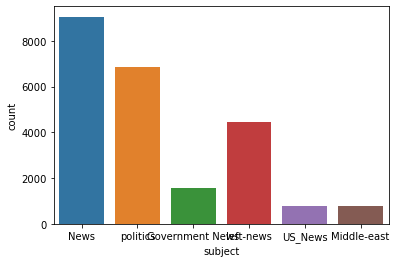

In [100]:
sns.countplot(x="subject", data=real)
plt.show()

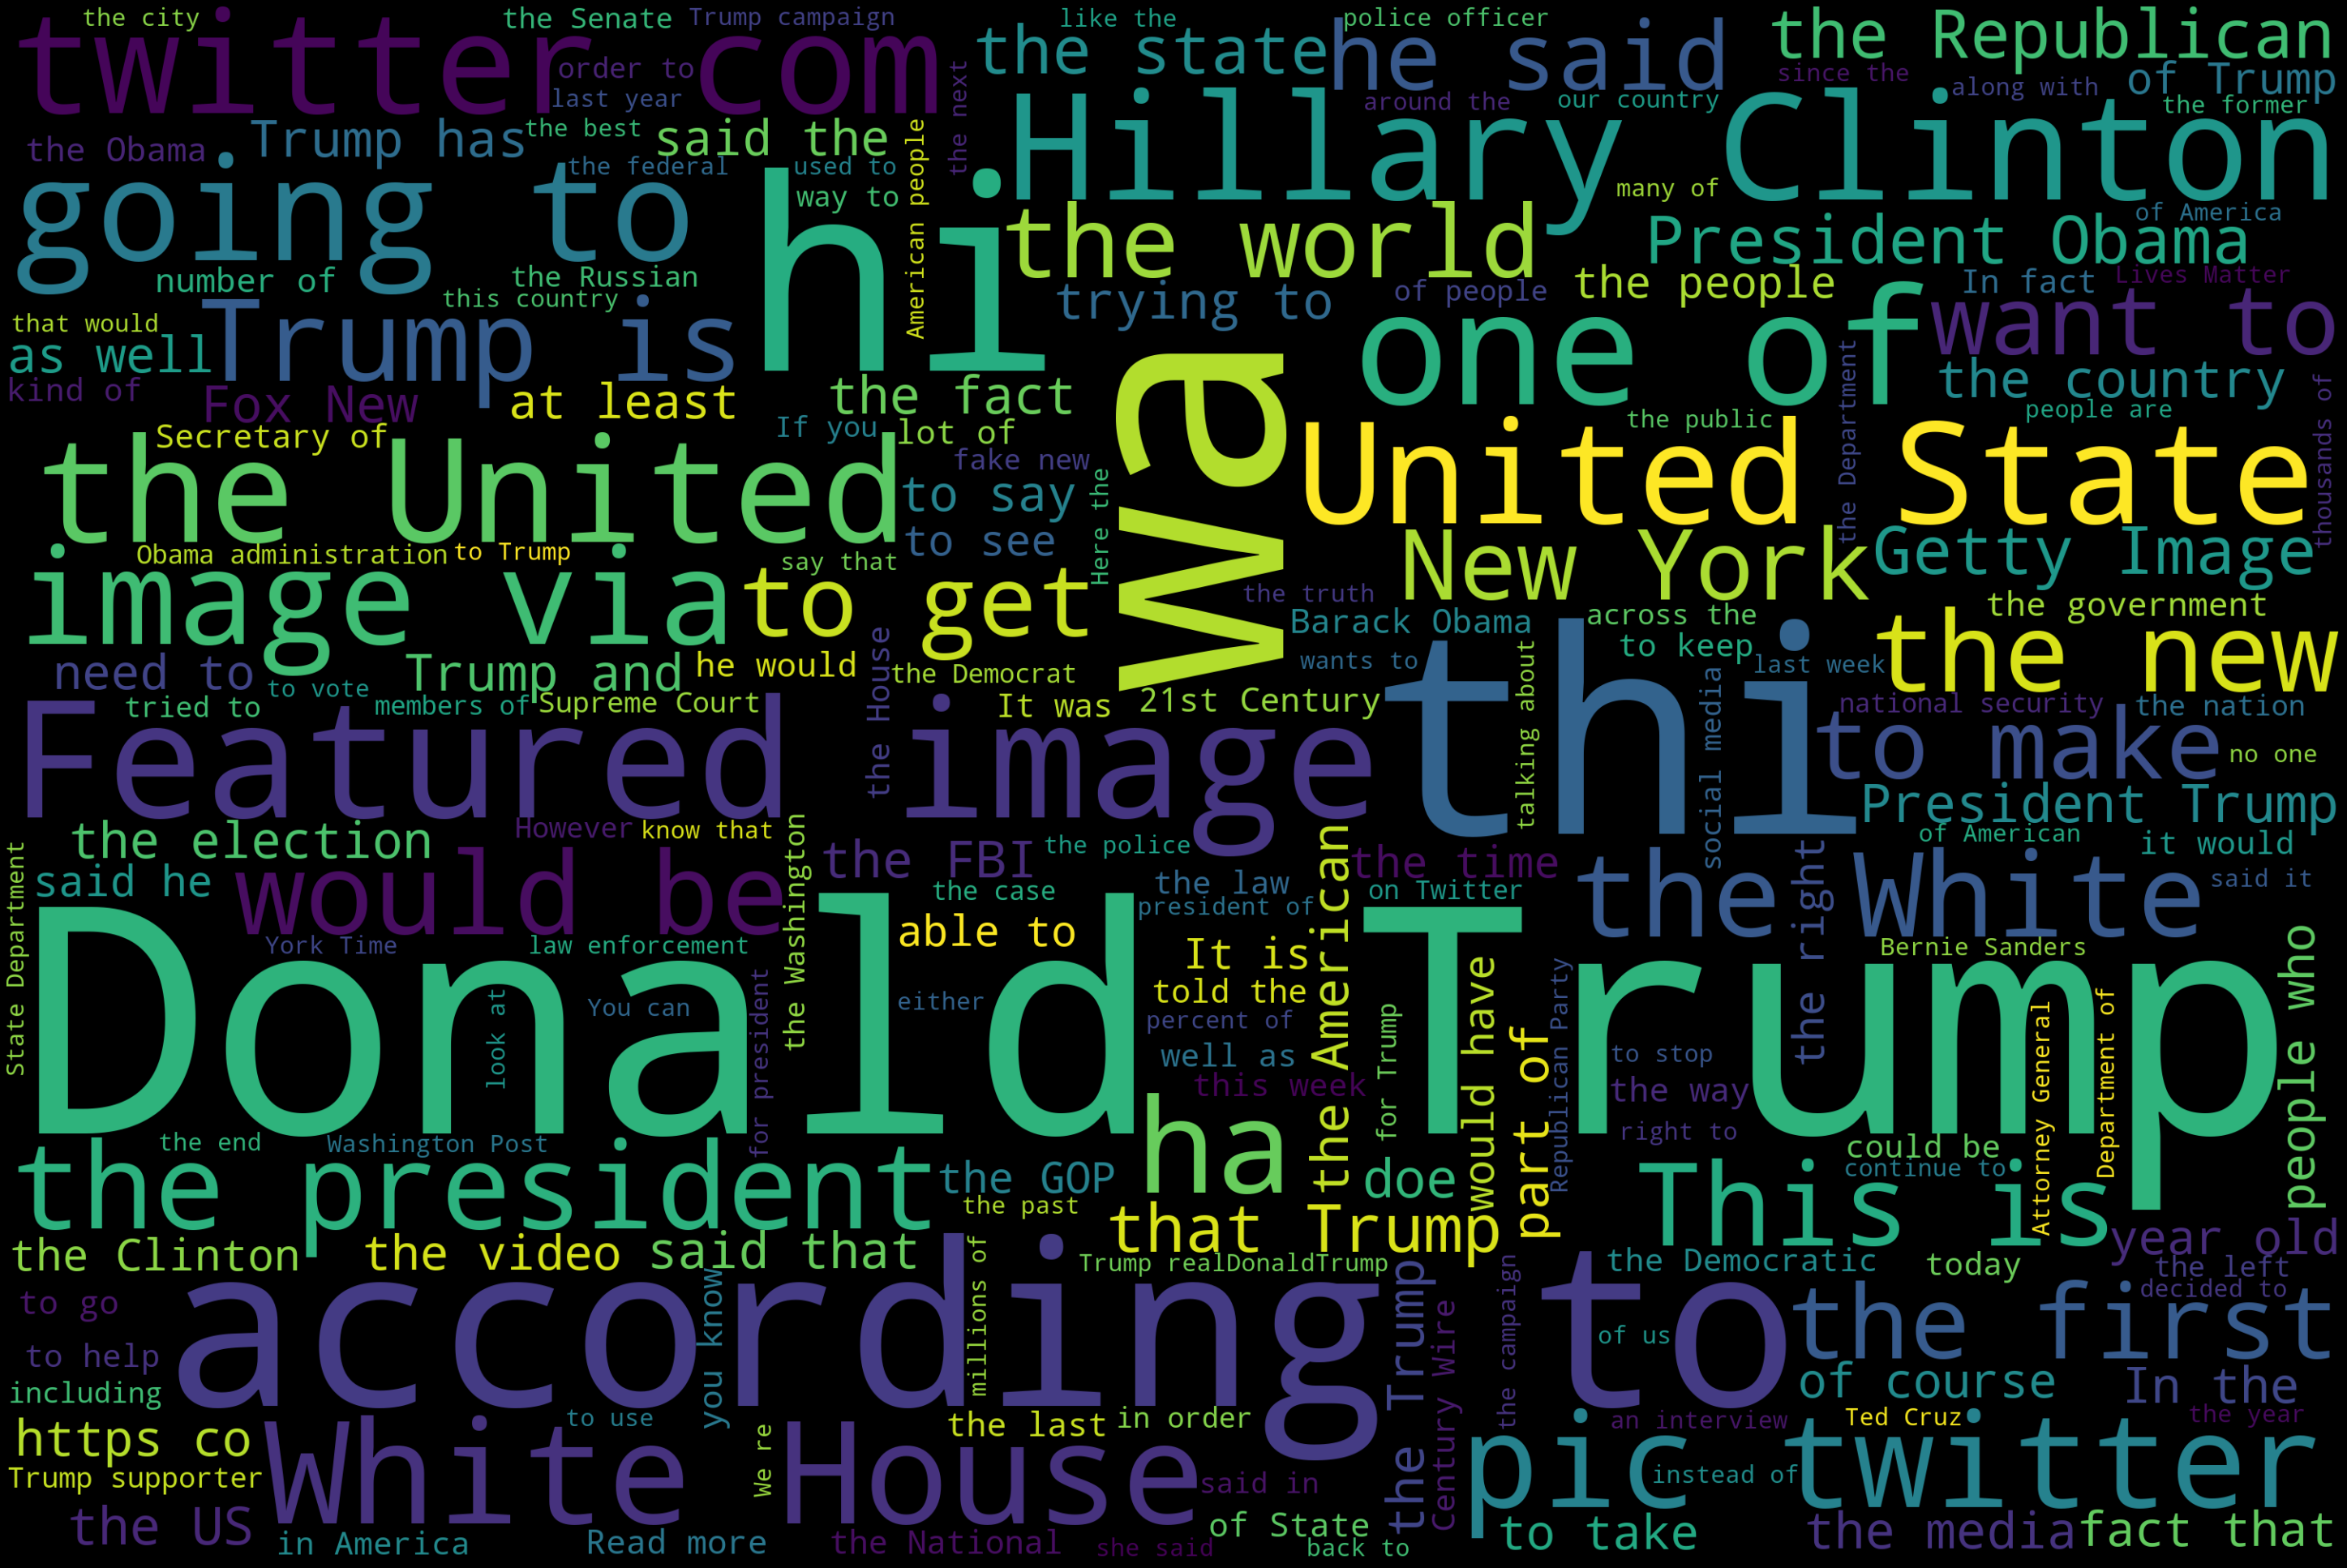

In [101]:
#WordCloud For Real News
text = ''
for news in real.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [102]:
# Adding class Information
real["class"] = 1
fake["class"] = 0

In [103]:
#Combining Title and Text
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [104]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
real = real.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [105]:
#Combining both into new dataframe
data = real.append(fake, ignore_index=True)
del real, fake

In [106]:
# Download following if not downloaded in local machine

# nltk.download('stopwords')
# nltk.download('punkt')

In [107]:
y = data["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data


In [108]:
import gensim

In [109]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [110]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 122248 words by a 100dim vector.

122366

In [111]:
#see a sample vector for random word, lets say Corona 
w2v_model["corona"]

array([ 0.0714223 , -0.0383811 , -0.03931856,  0.05930443, -0.04275804,
       -0.01406049, -0.05676581,  0.01562453, -0.02510898,  0.04401163,
       -0.04231574,  0.04979935, -0.04758988, -0.04836034,  0.05104336,
        0.03611033, -0.00290001,  0.0044905 , -0.01685121, -0.02807602,
        0.07174067, -0.00098574, -0.03644021, -0.00360815, -0.04020093,
        0.01166495,  0.00173461,  0.0109212 , -0.01382725,  0.00105083,
        0.08531322,  0.00231945,  0.05504247,  0.06045968,  0.05206728,
       -0.01356501,  0.04450537, -0.02159269,  0.04781694,  0.00213314,
        0.03843735,  0.01900962, -0.05344589, -0.05713987, -0.00303766,
       -0.01401724,  0.08445068,  0.04686094, -0.04642088,  0.01145415,
        0.01820931, -0.08975387, -0.02989481, -0.03991359, -0.11367396,
       -0.08432849, -0.0208638 ,  0.01162845, -0.09699893,  0.0151767 ,
       -0.02117142, -0.03266005, -0.00214574, -0.06968272,  0.00662453,
       -0.03784832, -0.05418086, -0.02338609, -0.0334656 ,  0.02

In [112]:
w2v_model.wv.most_similar("iran")

[('tehran', 0.8794088959693909),
 ('iranian', 0.7363796234130859),
 ('destabilizing', 0.6344166398048401),
 ('iranians', 0.6267366409301758),
 ('hezbollah', 0.6071474552154541),
 ('saudis', 0.5994256138801575),
 ('nuclear', 0.588266134262085),
 ('jcpoa', 0.5772654414176941),
 ('pyongyang', 0.5765438675880432),
 ('sanctions', 0.5745843052864075)]

In [113]:
w2v_model.wv.most_similar("fbi")

[('comey', 0.7417721152305603),
 ('cia', 0.6393689513206482),
 ('investigators', 0.6146782636642456),
 ('mueller', 0.5955888628959656),
 ('doj', 0.5935266613960266),
 ('investigation', 0.5849518775939941),
 ('nunes', 0.5802596807479858),
 ('investigations', 0.5675244331359863),
 ('leakin', 0.5553516745567322),
 ('inquiry', 0.5383029580116272)]

In [114]:
w2v_model.wv.most_similar("facebook")

[('instagram', 0.639788806438446),
 ('gofundme', 0.6208773851394653),
 ('fb', 0.6185976266860962),
 ('reddit', 0.602439820766449),
 ('google', 0.5917935967445374),
 ('4chan', 0.5745011568069458),
 ('whatsapp', 0.5569536685943604),
 ('online', 0.5564197301864624),
 ('linkedin', 0.5534355044364929),
 ('blog', 0.5520593523979187)]

In [115]:
w2v_model.wv.most_similar("computer")

[('computers', 0.8489668369293213),
 ('software', 0.7881981134414673),
 ('malware', 0.7589119672775269),
 ('servers', 0.7515531778335571),
 ('laptop', 0.7488323450088501),
 ('electronic', 0.740904688835144),
 ('scanning', 0.7101810574531555),
 ('kaspersky', 0.6920015215873718),
 ('devices', 0.6904141902923584),
 ('unclassified', 0.6803724765777588)]

In [116]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

[('incoming', 0.543134331703186),
 ('elect', 0.533397376537323),
 ('bartlet', 0.518429696559906),
 ('bush', 0.49218079447746277),
 ('2017blumenthal', 0.48072758316993713),
 ('hillary', 0.47722357511520386),
 ('americas_dad', 0.47131744027137756),
 ('cruz', 0.46680599451065063),
 ('sanders', 0.4449808597564697),
 ('however', 0.4387871325016022)]

In [117]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [119]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[14, 1, 4829, 2612, 8, 18, 4415, 527, 2693, 14]

In [120]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break 

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


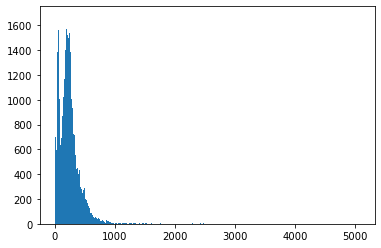

In [121]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :)

In [122]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
# Out of 48k news, 44k have less than 700 words

43977

In [123]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [124]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [125]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [126]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [127]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [128]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [129]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 100)          12236700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 12,354,077
Trainable params: 117,377
Non-trainable params: 12,236,700
_________________________________________________________________


In [130]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

SyntaxError: invalid syntax (<ipython-input-130-caa2015fa461>, line 1)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

In [ ]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))